In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

import os, shutil
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms

import h5py
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt


import torchvision
from torchvision.models import vgg16

import tqdm

In [2]:
original_dataset_dir = 'C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection'

In [3]:
train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

In [4]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [5]:
   
    
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    

In [6]:
model = CNN()

In [7]:
import torchsummary
model = CNN()
torchsummary.summary(model, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
            Linear-9                  [-1, 512]       3,211,776
           Linear-10                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 11.53
Params size (MB): 13.17
Estim

In [8]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

In [9]:

train_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0,), (1/255,))
])

train_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/train_another', transform=train_datagen)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

validation_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0,), (1/255,))
])

val_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/validation_another', transform=validation_datagen)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)



In [ ]:

training_loss = []
validation_loss = []
training_acc = []
validation_acc = []
epoch_nums=[]


for epoch in range(5):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
#        train_loss += loss.item()
#        train_acc += (outputs.round().squeeze().long() == labels).float().mean().item()
        if (i+1) % 100 == 0: # 100 steps per epoch
            print('Epoch %d/50' % (epoch+1))
            print('100/100 [==============================] - %d ms/step - loss: %.4f - acc: %.4f' % ((i+1), train_loss/100, train_acc/100))
            train_loss = 0.0
            train_acc = 0.0
            
    with torch.no_grad():
        val_loss = 0.0
        val_acc = 0.0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()
            val_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
            if (i+1) % 50 == 0: # 100 steps per epoch
                break
        val_loss /= 50
        val_acc /= 50
        print('Epoch %d/50' % (epoch+1))
        print('100/100 [==============================] - %d ms/step - loss: %.4f - acc: %.4f - val_loss: %.4f - val_acc: %.4f' % (100, train_loss/100, train_acc/100, val_loss, val_acc))

    epoch_nums.append(epoch+1)
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    training_loss.append(train_loss/100)
    training_acc.append(train_acc/100)

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

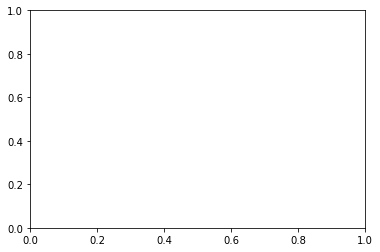

In [34]:

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:

training_loss = []
validation_loss = []
training_acc = []
validation_acc = []


for epoch in range(5):
    running_loss = 0.0
    running_corrects = 0
    val_running_loss = 0.0
    val_running_corrects = 0
    
    print("Epoch {}/50".format(epoch+1))
    
    # Entraînement
    for i, data in enumerate(train_loader, 0):
        # Obtient les entrées et les étiquettes
        inputs, labels = data
        
        # Initialise les gradients à zéro
        optimizer.zero_grad()
        
        # Calcul les prédictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels.float())
        
        # Effectue la rétropropagation et l'optimisation
        loss.backward()
        optimizer.step()
        
        # Calcule la perte et le nombre de prédictions correctes pour ce lot
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        # Arrête l'entraînement après 100 lots
        if i == 99:
            break
    
    # Calcul la perte et le taux d'exactitude pour l'ensemble d'entraînement
    train_loss = running_loss / 100.0
    train_acc = running_corrects.double() / (100.0 * labels.size(0))
    
    # Validation
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # Obtient les entrées et les étiquettes
            inputs, labels = data
            
            # Calcul les prédictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels.float())
            
            # Calcule la perte et le nombre de prédictions correctes pour ce lot
            val_running_loss += loss.item()
            val_running_corrects += torch.sum(preds == labels.data)
            
            # Arrête la validation après 50 lots
            if i == 49:
                break
    
    # Calcul la perte et le taux d'exactitude pour l'ensemble de validation
    val_loss = val_running_loss / 50.0
    val_acc = val_running_corrects.double() / (50.0 * labels.size(0))

    
    # Print the training and validation loss and accuracy
    print(f'Epoch {epoch + 1}/{num_epochs}\nTrain Loss: {train_loss:.6f}\tTrain Acc: {train_acc:.6f}\tVal Loss: {val_loss:.6f}\tVal Acc: {val_acc:.6f}')
    
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    training_loss.append(train_loss)
    training_acc.append(train_acc)